In [139]:
#import necessary packages
import pandas as pd 
import splitfolders
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers import scikit_learn
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import models, layers, optimizers, regularizers
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import joblib

In [ ]:
def pickle_model(model):
    
    file_name = input("What would you like to name the model?")
    file_name = file_name.replace(' ', '')
    # use the built-in open() function to open a file
    output_file = open(f"./models/{file_name}.pkl", "wb") # "wb" means "write as bytes"
    # dump the variable's contents into the file
    joblib.dump(model, output_file)
    # close the file, ensuring nothing stays in the buffer
    output_file.close()
    

In [ ]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook

#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [ ]:
simple_train_data = train_data.reshape(train_data.shape[0], -1)
simple_test_data = test_data.reshape(test_data.shape[0], -1)
simple_val_data = val_data.reshape(val_data.shape[0], -1)

In [ ]:
train_data.shape

In [ ]:
simple_model = models.Sequential()

In [ ]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
simple_model.compile(optimizer='SGD', 
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [ ]:
simple_model.summary()

In [ ]:
simple_fit = simple_model.fit(simple_train_data,
                                  train_labels,
                                  epochs=5,
                                  batch_size=32,
                                  validation_data=(val_data,val_labels),
                                  verbose=1)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150,150,1)))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))       
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(12, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model.summary()

In [ ]:
cnn_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [ ]:
cnn_model_fit = cnn_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels), verbose=1)

## Image Augmentation

In [2]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=30, 
                             width_shift_range=0.25, 
                             height_shift_range=0.25, 
                             shear_range=0.25, 
                             zoom_range=0.25, 
                             horizontal_flip=True,
                             vertical_flip=True)

In [3]:
train_generator = datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary', 
        color_mode='grayscale')

Found 3749 images belonging to 2 classes.


In [4]:
#create a validation_generator from the training directory that has been created from the split folders package
validation_generator = datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        class_mode='binary',
                                                        color_mode='grayscale')

Found 936 images belonging to 2 classes.


In [5]:
#create a test_generator from the training directory that has been created from the split folders package
test_generator = datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  class_mode='binary',
                                                  color_mode='grayscale')

Found 1107 images belonging to 2 classes.


In [6]:
train_data, train_labels = next(train_generator)
val_data, val_labels = next(validation_generator)
test_data, test_labels = next(test_generator)

## Simple Model

In [ ]:
simple_model = Sequential()
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid'))
simple_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])


In [ ]:
simple_train_data = train_data.reshape(train_data.shape[0], -1)
simple_test_data = test_data.reshape(test_data.shape[0], -1)
simple_val_data = val_data.reshape(val_data.shape[0], -1)

In [ ]:
simple_model_fit = simple_model.fit(simple_train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (simple_val_data, val_labels), verbose=1)

In [ ]:
simple_modle = model.save()

In [ ]:
simple_model_fit.history

In [ ]:
train_loss = simple_model_fit.history['loss']
train_acc = simple_model_fit.history['accuracy']
val_loss = simple_model_fit.history['val_loss']
val_acc = simple_model_fit.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=simple_model_fit.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=simple_model_fit.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=simple_model_fit.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=simple_model_fit.epoch, y=val_acc, ax=ax2, label='val_accuracy');

## CNN model

CNN model has many hyperparameters we can tune. Using different hyperparameters would cause a big difference on the result. So I will do some grid search on the CNN model and find some hyperparameters that lead to better result.

In [7]:
loss = 'binary_crossentropy'
metric_ls = ['accuracy', metrics.Precision(), metrics.Recall()]
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=20)

In [ ]:
def cnn_model():  
    model = Sequential()
    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))       
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss=loss, metrics=metric_ls)
    return model

I will start with batch size and epochs. Those are very important hyperparameters when building the neural network model.

In [ ]:
# I'll grid search the following batch size and epochs
batch_size = [16, 32, 64]
epochs = [10, 20, 30]

In [ ]:
model = KerasClassifier(cnn_model, verbose=2)

In [ ]:
# grid search parameters
params = dict(batch_size = batch_size,epochs = epochs)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=params, cv=5)

In [ ]:
results = grid.fit(train_data, train_labels, callbacks=[early_stop])

In [ ]:
results.best_score_

In [ ]:
results.best_params_

### Best param

Based on previous grid search result, the batch size is 64 and epochs is 30. Now using the best batch size and epochs to run the model.

In [60]:
gridsearch_model = Sequential()
gridsearch_model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
gridsearch_model.add(layers.MaxPooling2D((2,2)))
gridsearch_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
gridsearch_model.add(layers.MaxPooling2D((2,2)))
gridsearch_model.add(layers.Flatten())
gridsearch_model.add(layers.Dense(12, activation='relu'))
gridsearch_model.add(layers.Dense(1, activation='sigmoid'))
gridsearch_model.compile(optimizer='Adam', loss=loss, metrics=metric_ls)

In [61]:
better_model1 = gridsearch_model.fit(train_data, train_labels, batch_size=64, epochs=30, validation_data=(val_data, val_labels),callbacks=early_stop)

Epoch 1/30
59/59 [==============================] - 28s 475ms/step - loss: 0.5691 - accuracy: 0.7282 - precision: 0.7567 - recall: 0.9789 - val_loss: 0.5002 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/30
59/59 [==============================] - 28s 477ms/step - loss: 0.4912 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.4683 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/30
59/59 [==============================] - 30s 508ms/step - loss: 0.4605 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.4309 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 4/30
59/59 [==============================] - 30s 501ms/step - loss: 0.4219 - accuracy: 0.7623 - precision: 0.7689 - recall: 0.9642 - val_loss: 0.3818 - val_accuracy: 0.8216 - val_precision: 0.8386 - val_recall: 0.9356
Epoch 5/30
59/59 [==============================] - 31s 518ms/step - loss: 0.4093 - accuracy: 0.8005

In [ ]:
# save model for later use
better_model1.save('models/cnn_model1')

In [25]:
loaded_cnn_model1 = load_model('models/cnn_model1')

In [59]:
train_loss = better_model1.history['loss']
train_acc = better_model1.history['accuracy']
val_loss = better_model1.history['val_loss']
val_acc = better_model1.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=better_model1.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=better_model1.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=better_model1.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=better_model1.epoch, y=val_acc, ax=ax2, label='val_accuracy');

NameError: name 'gridsearch_model' is not defined

In [8]:
def cnn_model2(dropout_rate):  
    model = Sequential()
    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))       
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss=loss, metrics=metric_ls)
    return model

In [9]:
model2 = KerasClassifier(cnn_model2, batch_size=64, epochs=30, verbose=2)

In [10]:
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [11]:
params = dict(model__dropout_rate=dropout_rate)

In [12]:
grid = GridSearchCV(estimator=model2, param_grid=params, cv=5)

In [13]:
model2_results = grid.fit(train_data, train_labels, callbacks=[early_stop])

Epoch 1/30
47/47 - 38s - loss: 0.5907 - accuracy: 0.7162 - precision: 0.7268 - recall: 0.9790 - 38s/epoch - 803ms/step
Epoch 2/30
47/47 - 37s - loss: 0.5166 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 37s/epoch - 790ms/step
Epoch 3/30
47/47 - 37s - loss: 0.4666 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 37s/epoch - 789ms/step
Epoch 4/30
47/47 - 38s - loss: 0.4530 - accuracy: 0.7569 - precision: 0.7597 - recall: 0.9753 - 38s/epoch - 799ms/step
Epoch 5/30
47/47 - 37s - loss: 0.4210 - accuracy: 0.7899 - precision: 0.8323 - recall: 0.8917 - 37s/epoch - 789ms/step
Epoch 6/30
47/47 - 37s - loss: 0.4130 - accuracy: 0.8053 - precision: 0.8410 - recall: 0.9040 - 37s/epoch - 795ms/step
Epoch 7/30
47/47 - 37s - loss: 0.3871 - accuracy: 0.8186 - precision: 0.8568 - recall: 0.9022 - 37s/epoch - 793ms/step
Epoch 8/30
47/47 - 38s - loss: 0.3840 - accuracy: 0.8209 - precision: 0.8654 - recall: 0.8935 - 38s/epoch - 806ms/step
Epoch 9/30
47/47 - 37s - loss: 0.3609 - accuracy

Epoch 9/30
47/47 - 39s - loss: 0.2974 - accuracy: 0.8850 - precision: 0.8981 - recall: 0.9502 - 39s/epoch - 830ms/step
Epoch 10/30
47/47 - 39s - loss: 0.2776 - accuracy: 0.8983 - precision: 0.9106 - recall: 0.9543 - 39s/epoch - 824ms/step
Epoch 11/30
47/47 - 38s - loss: 0.2725 - accuracy: 0.8993 - precision: 0.9111 - recall: 0.9552 - 38s/epoch - 811ms/step
Epoch 12/30
47/47 - 38s - loss: 0.2474 - accuracy: 0.9216 - precision: 0.9342 - recall: 0.9603 - 38s/epoch - 810ms/step
Epoch 13/30
47/47 - 38s - loss: 0.2168 - accuracy: 0.9450 - precision: 0.9514 - recall: 0.9744 - 38s/epoch - 809ms/step
Epoch 14/30
47/47 - 39s - loss: 0.2106 - accuracy: 0.9490 - precision: 0.9594 - recall: 0.9712 - 39s/epoch - 825ms/step
Epoch 15/30
47/47 - 39s - loss: 0.1948 - accuracy: 0.9600 - precision: 0.9658 - recall: 0.9799 - 39s/epoch - 826ms/step
Epoch 16/30
47/47 - 39s - loss: 0.1805 - accuracy: 0.9690 - precision: 0.9764 - recall: 0.9813 - 39s/epoch - 832ms/step
Epoch 17/30
47/47 - 39s - loss: 0.1704 - 

Epoch 17/30
47/47 - 38s - loss: 0.1780 - accuracy: 0.9690 - precision: 0.9764 - recall: 0.9813 - 38s/epoch - 814ms/step
Epoch 18/30
47/47 - 38s - loss: 0.1641 - accuracy: 0.9743 - precision: 0.9787 - recall: 0.9863 - 38s/epoch - 816ms/step
Epoch 19/30
47/47 - 39s - loss: 0.1483 - accuracy: 0.9837 - precision: 0.9917 - recall: 0.9858 - 39s/epoch - 820ms/step
Epoch 20/30
47/47 - 38s - loss: 0.1425 - accuracy: 0.9860 - precision: 0.9927 - recall: 0.9881 - 38s/epoch - 811ms/step
Epoch 21/30
47/47 - 38s - loss: 0.1344 - accuracy: 0.9883 - precision: 0.9954 - recall: 0.9886 - 38s/epoch - 807ms/step
Epoch 22/30
47/47 - 38s - loss: 0.1281 - accuracy: 0.9900 - precision: 0.9963 - recall: 0.9899 - 38s/epoch - 814ms/step
Epoch 23/30
47/47 - 38s - loss: 0.1221 - accuracy: 0.9917 - precision: 0.9972 - recall: 0.9913 - 38s/epoch - 817ms/step
Epoch 24/30
47/47 - 39s - loss: 0.1187 - accuracy: 0.9917 - precision: 0.9968 - recall: 0.9918 - 39s/epoch - 826ms/step
Epoch 25/30
47/47 - 38s - loss: 0.1097 -

Epoch 25/30
47/47 - 39s - loss: 0.0874 - accuracy: 0.9693 - precision: 0.9847 - recall: 0.9730 - 39s/epoch - 823ms/step
Epoch 26/30
47/47 - 39s - loss: 0.0773 - accuracy: 0.9733 - precision: 0.9880 - recall: 0.9753 - 39s/epoch - 831ms/step
Epoch 27/30
47/47 - 39s - loss: 0.0757 - accuracy: 0.9730 - precision: 0.9880 - recall: 0.9749 - 39s/epoch - 820ms/step
Epoch 28/30
47/47 - 38s - loss: 0.0593 - accuracy: 0.9800 - precision: 0.9908 - recall: 0.9817 - 38s/epoch - 819ms/step
Epoch 29/30
47/47 - 38s - loss: 0.0688 - accuracy: 0.9760 - precision: 0.9889 - recall: 0.9781 - 38s/epoch - 811ms/step
Epoch 30/30
47/47 - 39s - loss: 0.0602 - accuracy: 0.9827 - precision: 0.9940 - recall: 0.9822 - 39s/epoch - 821ms/step
12/12 - 2s - 2s/epoch - 193ms/step
Epoch 1/30
47/47 - 40s - loss: 0.5976 - accuracy: 0.7279 - precision: 0.8410 - recall: 0.9886 - 40s/epoch - 846ms/step
Epoch 2/30
47/47 - 39s - loss: 0.5264 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 39s/epoch - 820ms/step
Epoch 3

Epoch 3/30
47/47 - 40s - loss: 0.4790 - accuracy: 0.7297 - precision: 0.7297 - recall: 1.0000 - 40s/epoch - 851ms/step
Epoch 4/30
47/47 - 40s - loss: 0.4280 - accuracy: 0.7297 - precision: 0.7297 - recall: 1.0000 - 40s/epoch - 857ms/step
Epoch 5/30
47/47 - 40s - loss: 0.4032 - accuracy: 0.7840 - precision: 0.7995 - recall: 0.9397 - 40s/epoch - 846ms/step
Epoch 6/30
47/47 - 40s - loss: 0.3883 - accuracy: 0.8107 - precision: 0.8387 - recall: 0.9169 - 40s/epoch - 849ms/step
Epoch 7/30
47/47 - 39s - loss: 0.3880 - accuracy: 0.8230 - precision: 0.8620 - recall: 0.9018 - 39s/epoch - 837ms/step
Epoch 8/30
47/47 - 40s - loss: 0.3504 - accuracy: 0.8563 - precision: 0.8822 - recall: 0.9269 - 40s/epoch - 855ms/step
Epoch 9/30
47/47 - 40s - loss: 0.3663 - accuracy: 0.8363 - precision: 0.8734 - recall: 0.9073 - 40s/epoch - 843ms/step
Epoch 10/30
47/47 - 40s - loss: 0.3475 - accuracy: 0.8467 - precision: 0.8964 - recall: 0.8931 - 40s/epoch - 854ms/step
Epoch 11/30
47/47 - 39s - loss: 0.3562 - accura

Epoch 11/30
47/47 - 39s - loss: 0.2509 - accuracy: 0.8896 - precision: 0.9166 - recall: 0.9338 - 39s/epoch - 836ms/step
Epoch 12/30
47/47 - 39s - loss: 0.2214 - accuracy: 0.9050 - precision: 0.9316 - recall: 0.9388 - 39s/epoch - 831ms/step
Epoch 13/30
47/47 - 39s - loss: 0.2034 - accuracy: 0.9160 - precision: 0.9420 - recall: 0.9429 - 39s/epoch - 832ms/step
Epoch 14/30
47/47 - 39s - loss: 0.1869 - accuracy: 0.9273 - precision: 0.9523 - recall: 0.9479 - 39s/epoch - 829ms/step
Epoch 15/30
47/47 - 39s - loss: 0.1626 - accuracy: 0.9343 - precision: 0.9519 - recall: 0.9584 - 39s/epoch - 837ms/step
Epoch 16/30
47/47 - 40s - loss: 0.1330 - accuracy: 0.9493 - precision: 0.9623 - recall: 0.9685 - 40s/epoch - 846ms/step
Epoch 17/30
47/47 - 40s - loss: 0.1254 - accuracy: 0.9523 - precision: 0.9658 - recall: 0.9689 - 40s/epoch - 844ms/step
Epoch 18/30
47/47 - 39s - loss: 0.1094 - accuracy: 0.9597 - precision: 0.9704 - recall: 0.9744 - 39s/epoch - 836ms/step
Epoch 19/30
47/47 - 39s - loss: 0.1174 -

Epoch 19/30
47/47 - 40s - loss: 0.1367 - accuracy: 0.9186 - precision: 0.9183 - recall: 0.9753 - 40s/epoch - 843ms/step
Epoch 20/30
47/47 - 39s - loss: 0.1396 - accuracy: 0.9203 - precision: 0.9177 - recall: 0.9785 - 39s/epoch - 834ms/step
Epoch 21/30
47/47 - 39s - loss: 0.1351 - accuracy: 0.9163 - precision: 0.9166 - recall: 0.9740 - 39s/epoch - 835ms/step
Epoch 22/30
47/47 - 40s - loss: 0.1291 - accuracy: 0.9396 - precision: 0.9640 - recall: 0.9529 - 40s/epoch - 845ms/step
Epoch 23/30
47/47 - 40s - loss: 0.1100 - accuracy: 0.9537 - precision: 0.9767 - recall: 0.9593 - 40s/epoch - 849ms/step
Epoch 24/30
47/47 - 40s - loss: 0.1058 - accuracy: 0.9567 - precision: 0.9777 - recall: 0.9625 - 40s/epoch - 846ms/step
Epoch 25/30
47/47 - 40s - loss: 0.0975 - accuracy: 0.9570 - precision: 0.9782 - recall: 0.9625 - 40s/epoch - 843ms/step
Epoch 26/30
47/47 - 39s - loss: 0.0999 - accuracy: 0.9607 - precision: 0.9805 - recall: 0.9653 - 39s/epoch - 838ms/step
Epoch 27/30
47/47 - 39s - loss: 0.0941 -

Epoch 27/30
47/47 - 38s - loss: 0.2182 - accuracy: 0.9223 - precision: 0.9706 - recall: 0.9214 - 38s/epoch - 818ms/step
Epoch 28/30
47/47 - 38s - loss: 0.2065 - accuracy: 0.9283 - precision: 0.9763 - recall: 0.9241 - 38s/epoch - 817ms/step
Epoch 29/30
47/47 - 38s - loss: 0.1945 - accuracy: 0.9383 - precision: 0.9808 - recall: 0.9337 - 38s/epoch - 819ms/step
Epoch 30/30
47/47 - 39s - loss: 0.2046 - accuracy: 0.9303 - precision: 0.9678 - recall: 0.9356 - 39s/epoch - 819ms/step
12/12 - 2s - 2s/epoch - 188ms/step
Epoch 1/30
47/47 - 42s - loss: 0.6204 - accuracy: 0.7272 - precision: 0.8284 - recall: 0.9653 - 42s/epoch - 901ms/step
Epoch 2/30
47/47 - 41s - loss: 0.5998 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 41s/epoch - 873ms/step
Epoch 3/30
47/47 - 41s - loss: 0.5508 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 41s/epoch - 870ms/step
Epoch 4/30
47/47 - 41s - loss: 0.5147 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 41s/epoch - 873ms/step
Epoch 5/3

Epoch 5/30
47/47 - 40s - loss: 0.4429 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 40s/epoch - 849ms/step
Epoch 6/30
47/47 - 40s - loss: 0.4177 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 40s/epoch - 848ms/step
Epoch 7/30
47/47 - 40s - loss: 0.3741 - accuracy: 0.7409 - precision: 0.7416 - recall: 0.9899 - 40s/epoch - 851ms/step
Epoch 8/30
47/47 - 40s - loss: 0.4039 - accuracy: 0.8039 - precision: 0.8725 - recall: 0.8566 - 40s/epoch - 844ms/step
Epoch 9/30
47/47 - 39s - loss: 0.4025 - accuracy: 0.7976 - precision: 0.8599 - recall: 0.8634 - 39s/epoch - 830ms/step
Epoch 10/30
47/47 - 39s - loss: 0.3626 - accuracy: 0.8446 - precision: 0.8946 - recall: 0.8922 - 39s/epoch - 825ms/step
Epoch 11/30
47/47 - 39s - loss: 0.3523 - accuracy: 0.8436 - precision: 0.8956 - recall: 0.8894 - 39s/epoch - 837ms/step
Epoch 12/30
47/47 - 40s - loss: 0.3418 - accuracy: 0.8419 - precision: 0.8961 - recall: 0.8862 - 40s/epoch - 841ms/step
Epoch 13/30
47/47 - 39s - loss: 0.3414 - accu

Epoch 13/30
47/47 - 39s - loss: 0.3767 - accuracy: 0.8323 - precision: 0.9060 - recall: 0.8592 - 39s/epoch - 819ms/step
Epoch 14/30
47/47 - 39s - loss: 0.3617 - accuracy: 0.8293 - precision: 0.8994 - recall: 0.8624 - 39s/epoch - 819ms/step
Epoch 15/30
47/47 - 39s - loss: 0.3541 - accuracy: 0.8433 - precision: 0.9087 - recall: 0.8729 - 39s/epoch - 821ms/step
Epoch 16/30
47/47 - 39s - loss: 0.3561 - accuracy: 0.8383 - precision: 0.9072 - recall: 0.8670 - 39s/epoch - 821ms/step
Epoch 17/30
47/47 - 38s - loss: 0.3329 - accuracy: 0.8516 - precision: 0.9156 - recall: 0.8775 - 38s/epoch - 818ms/step
Epoch 18/30
47/47 - 38s - loss: 0.3151 - accuracy: 0.8673 - precision: 0.9262 - recall: 0.8889 - 38s/epoch - 815ms/step
Epoch 19/30
47/47 - 39s - loss: 0.3131 - accuracy: 0.8676 - precision: 0.9242 - recall: 0.8917 - 39s/epoch - 819ms/step
Epoch 20/30
47/47 - 38s - loss: 0.3193 - accuracy: 0.8650 - precision: 0.9305 - recall: 0.8807 - 38s/epoch - 818ms/step
Epoch 21/30
47/47 - 39s - loss: 0.2965 -

Epoch 21/30
47/47 - 38s - loss: 0.2897 - accuracy: 0.8833 - precision: 0.9444 - recall: 0.8926 - 38s/epoch - 814ms/step
Epoch 22/30
47/47 - 39s - loss: 0.2825 - accuracy: 0.8880 - precision: 0.9461 - recall: 0.8977 - 39s/epoch - 823ms/step
Epoch 23/30
47/47 - 38s - loss: 0.2590 - accuracy: 0.8973 - precision: 0.9546 - recall: 0.9022 - 38s/epoch - 812ms/step
Epoch 24/30
47/47 - 38s - loss: 0.2641 - accuracy: 0.8973 - precision: 0.9524 - recall: 0.9045 - 38s/epoch - 815ms/step
Epoch 25/30
47/47 - 38s - loss: 0.2476 - accuracy: 0.9043 - precision: 0.9608 - recall: 0.9059 - 38s/epoch - 817ms/step
Epoch 26/30
47/47 - 38s - loss: 0.2469 - accuracy: 0.9066 - precision: 0.9565 - recall: 0.9137 - 38s/epoch - 815ms/step
Epoch 27/30
47/47 - 38s - loss: 0.2505 - accuracy: 0.9050 - precision: 0.9608 - recall: 0.9068 - 38s/epoch - 809ms/step
Epoch 28/30
47/47 - 38s - loss: 0.2393 - accuracy: 0.9090 - precision: 0.9615 - recall: 0.9118 - 38s/epoch - 819ms/step
Epoch 29/30
47/47 - 38s - loss: 0.2355 -

Epoch 29/30
47/47 - 39s - loss: 0.3549 - accuracy: 0.7953 - precision: 0.9544 - recall: 0.7556 - 39s/epoch - 833ms/step
Epoch 30/30
47/47 - 39s - loss: 0.3425 - accuracy: 0.8070 - precision: 0.9579 - recall: 0.7693 - 39s/epoch - 834ms/step
12/12 - 2s - 2s/epoch - 179ms/step
Epoch 1/30
47/47 - 39s - loss: 0.6357 - accuracy: 0.7266 - precision: 0.8153 - recall: 0.8796 - 39s/epoch - 838ms/step
Epoch 2/30
47/47 - 38s - loss: 0.5907 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 38s/epoch - 818ms/step
Epoch 3/30
47/47 - 38s - loss: 0.5686 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 38s/epoch - 818ms/step
Epoch 4/30
47/47 - 38s - loss: 0.5497 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 38s/epoch - 811ms/step
Epoch 5/30
47/47 - 39s - loss: 0.5276 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 39s/epoch - 820ms/step
Epoch 6/30
47/47 - 39s - loss: 0.5204 - accuracy: 0.7296 - precision: 0.7296 - recall: 1.0000 - 39s/epoch - 821ms/step
Epoch 7/30


Epoch 7/30
47/47 - 38s - loss: 0.4742 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 38s/epoch - 818ms/step
Epoch 8/30
47/47 - 38s - loss: 0.4430 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 38s/epoch - 813ms/step
Epoch 9/30
47/47 - 38s - loss: 0.4469 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 38s/epoch - 811ms/step
Epoch 10/30
47/47 - 39s - loss: 0.4243 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 39s/epoch - 821ms/step
Epoch 11/30
47/47 - 39s - loss: 0.4106 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 39s/epoch - 821ms/step
Epoch 12/30
47/47 - 38s - loss: 0.3823 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 38s/epoch - 816ms/step
Epoch 13/30
47/47 - 39s - loss: 0.3877 - accuracy: 0.7299 - precision: 0.7299 - recall: 1.0000 - 39s/epoch - 819ms/step
Epoch 14/30
47/47 - 39s - loss: 0.3731 - accuracy: 0.7923 - precision: 0.8312 - recall: 0.8977 - 39s/epoch - 821ms/step
Epoch 15/30
47/47 - 38s - loss: 0.3682 - ac

Epoch 15/30
47/47 - 38s - loss: 0.3404 - accuracy: 0.8527 - precision: 0.9230 - recall: 0.8707 - 38s/epoch - 808ms/step
Epoch 16/30
47/47 - 38s - loss: 0.3447 - accuracy: 0.8417 - precision: 0.9259 - recall: 0.8511 - 38s/epoch - 814ms/step
Epoch 17/30
47/47 - 38s - loss: 0.3579 - accuracy: 0.8277 - precision: 0.9143 - recall: 0.8429 - 38s/epoch - 815ms/step
Epoch 18/30
47/47 - 38s - loss: 0.3443 - accuracy: 0.8387 - precision: 0.9330 - recall: 0.8392 - 38s/epoch - 799ms/step
Epoch 19/30
47/47 - 38s - loss: 0.3205 - accuracy: 0.8523 - precision: 0.9352 - recall: 0.8570 - 38s/epoch - 818ms/step
Epoch 20/30
47/47 - 39s - loss: 0.3225 - accuracy: 0.8497 - precision: 0.9416 - recall: 0.8465 - 39s/epoch - 820ms/step
Epoch 21/30
47/47 - 38s - loss: 0.3167 - accuracy: 0.8623 - precision: 0.9379 - recall: 0.8689 - 38s/epoch - 802ms/step
Epoch 22/30
47/47 - 38s - loss: 0.3109 - accuracy: 0.8580 - precision: 0.9427 - recall: 0.8575 - 38s/epoch - 814ms/step
Epoch 23/30
47/47 - 38s - loss: 0.3067 -

In [14]:
model2_results.best_params_

{'model__dropout_rate': 0.0}

In [15]:
model2_results.best_score_

0.8378232309746328

The best param is 0.0

Apply the best hyperparameters to the final model. 

In [53]:
dropout_model = Sequential()
dropout_model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
dropout_model.add(layers.MaxPooling2D((2,2)))
dropout_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
dropout_model.add(layers.MaxPooling2D((2,2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dropout(0.0))
dropout_model.add(layers.Dense(12, activation='relu'))
dropout_model.add(layers.Dropout(0.0))
dropout_model.add(layers.Dense(1, activation='sigmoid'))
dropout_model.compile(optimizer='Adam', loss=loss, metrics=metric_ls)

In [55]:
cnn_final = dropout_model.fit(train_data, train_labels, batch_size=64, epochs=30, validation_data=(val_data, val_labels),callbacks=early_stop)

Epoch 1/30
59/59 [==============================] - 51s 854ms/step - loss: 0.5683 - accuracy: 0.7298 - precision: 0.7566 - recall: 0.9789 - val_loss: 0.4848 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/30
59/59 [==============================] - 50s 849ms/step - loss: 0.4814 - accuracy: 0.7298 - precision: 0.7298 - recall: 1.0000 - val_loss: 0.5188 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 3/30
59/59 [==============================] - 50s 856ms/step - loss: 0.4348 - accuracy: 0.7485 - precision: 0.7539 - recall: 0.9730 - val_loss: 0.4037 - val_accuracy: 0.8162 - val_precision: 0.8297 - val_recall: 0.9414
Epoch 4/30
59/59 [==============================] - 51s 861ms/step - loss: 0.3931 - accuracy: 0.8149 - precision: 0.8343 - recall: 0.9313 - val_loss: 0.3880 - val_accuracy: 0.8397 - val_precision: 0.9171 - val_recall: 0.8580
Epoch 5/30
59/59 [==============================] - 51s 861ms/step - loss: 0.3653 - accuracy: 0.8410

In [50]:
dropout_model.save('models/cnn_final')

INFO:tensorflow:Assets written to: models/cnn_final\assets


INFO:tensorflow:Assets written to: models/cnn_final\assets


In [22]:
loaded_cnn_model2 = load_model('models/cnn_final')

In [37]:
cnn_final.history

{'loss': [0.583317220211029,
  0.4679816663265228,
  0.4268549382686615,
  0.39168694615364075,
  0.37130334973335266,
  0.3764570653438568,
  0.3425847291946411,
  0.3346746563911438,
  0.27189305424690247,
  0.2415049523115158,
  0.22908048331737518,
  0.17220887541770935,
  0.1281072050333023,
  0.0951562449336052,
  0.06934819370508194,
  0.0539291612803936,
  0.03824262320995331,
  0.026093680411577225,
  0.021671438589692116,
  0.02372598834335804,
  0.016629084944725037,
  0.015758251771330833,
  0.007833695970475674,
  0.005169737618416548,
  0.004504804499447346,
  0.003092844970524311,
  0.0025567449629306793,
  0.0024232908617705107,
  0.002041095634922385,
  0.001786787761375308],
 'accuracy': [0.7289943695068359,
  0.7297946214675903,
  0.7906108498573303,
  0.8132835626602173,
  0.8330221176147461,
  0.8247532844543457,
  0.8527607321739197,
  0.8490263819694519,
  0.8770338892936707,
  0.8938383460044861,
  0.9055747985839844,
  0.9311816692352295,
  0.9538543820381165,


In [56]:
model_results = loaded_cnn_model2.evaluate(validation_generator)

1/1 [==============================] - 12s 12s/step - loss: 0.5767 - accuracy: 0.8440 - precision: 0.8594 - recall: 0.9400


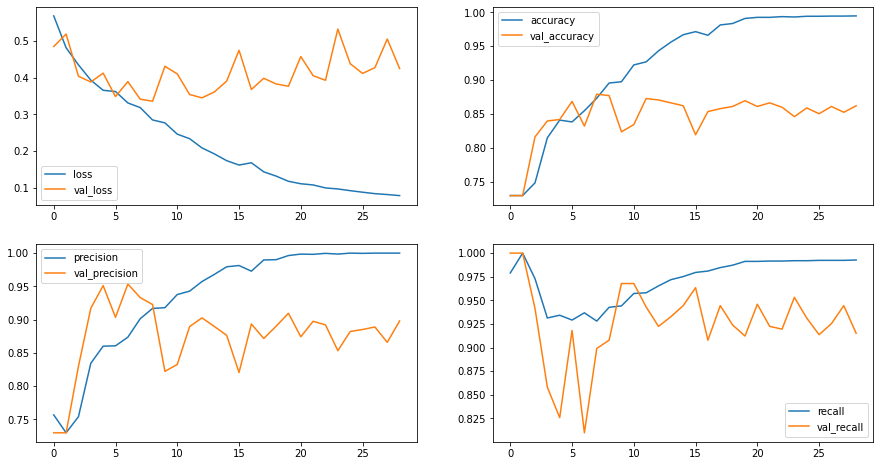

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['loss'], ax=ax1, label='loss')
sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['val_loss'], ax=ax1, label='val_loss')

sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['accuracy'], ax=ax2, label='accuracy')
sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['val_accuracy'], ax=ax2, label='val_accuracy')

sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['precision'], ax=ax3, label='precision')
sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['val_precision'], ax=ax3, label='val_precision')

sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['recall'], ax=ax4, label='recall')
sns.lineplot(x=cnn_final.epoch, y=cnn_final.history['val_recall'], ax=ax4, label='val_recall')
plt.savefig('cnn_metric.png');

In [119]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [120]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 3749 images belonging to 2 classes.


In [121]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1107 images belonging to 2 classes.


In [122]:
aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3749 images belonging to 2 classes.


In [129]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [140]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [131]:
cnn5_model = models.Sequential()
cnn5_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2, 2)))
cnn5_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2,2)))
cnn5_model.add(layers.Flatten())
cnn5_model.add(layers.Dense(16, activation='relu'))
cnn5_model.add(layers.Dropout(0.5))
cnn5_model.add(layers.Dense(1, activation='sigmoid'))

cnn5_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

cnn5_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 39200)             0         
                                                                 
 dense_76 (Dense)            (None, 16)              

In [132]:
cnn5_history = cnn5_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 28s 231ms/step - loss: 1.0974 - accuracy: 0.7234 - precision: 0.7304 - recall: 0.9843 - val_loss: 0.4515 - val_accuracy: 0.7297 - val_precision: 0.7297 - val_recall: 1.0000
Epoch 2/10
118/118 [==============================] - 28s 241ms/step - loss: 0.4760 - accuracy: 0.7431 - precision: 0.7509 - recall: 0.9697 - val_loss: 0.3565 - val_accuracy: 0.8889 - val_precision: 0.8765 - val_recall: 0.9868
Epoch 3/10
118/118 [==============================] - 29s 247ms/step - loss: 0.4368 - accuracy: 0.7911 - precision: 0.9094 - recall: 0.7928 - val_loss: 0.3482 - val_accuracy: 0.9145 - val_precision: 0.9229 - val_recall: 0.9634
Epoch 4/10
118/118 [==============================] - 29s 246ms/step - loss: 0.3930 - accuracy: 0.8218 - precision: 0.9179 - recall: 0.8300 - val_loss: 0.3169 - val_accuracy: 0.9177 - val_precision: 0.9244 - val_recall: 0.9663
Epoch 5/10
118/118 [==============================] - 29s 244ms/step - loss: 0.3721 - accura

In [142]:
cnn5_model.save('models/cnn5')

INFO:tensorflow:Assets written to: models/cnn5\assets


INFO:tensorflow:Assets written to: models/cnn5\assets


In [145]:
cnn5_test = load_model('models/cnn5')

In [146]:
y_pred = (cnn5_test.predict(val_data) > 0.5).astype("int32")
cm = confusion_matrix(y_true= val_labels, y_pred=y_pred)  

30/30 [==============================] - 2s 54ms/step


Confusion matrix, without normalization
[[209  44]
 [ 23 660]]


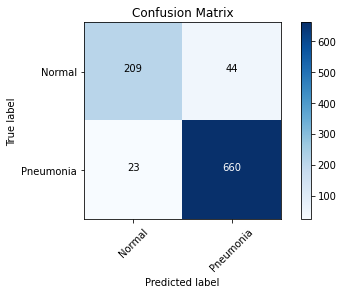

In [148]:
cm_labels = ['Normal','Pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix');

In [115]:
cm_labels = ['Normal','Pneumonia']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_labels)

In [118]:
cm

array([[  0, 253],
       [  0, 683]], dtype=int64)

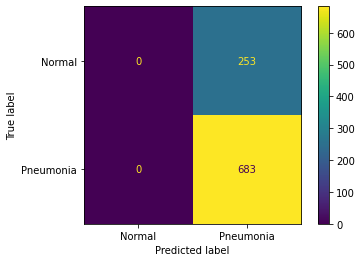

In [117]:
disp = disp.plot()

plt.show()